In [23]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

%reload_ext autoreload

In [22]:
import os
import numpy as np

import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

from tensorflow.keras import layers,models,utils
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [3]:
model = VGG16(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 520s 1us/step


In [12]:
img_path = './../data/misc/elephant.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [14]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 10us/step
Predicted: [('n02504458', 'African_elephant', 0.8474201), ('n01871265', 'tusker', 0.117097124), ('n02408429', 'water_buffalo', 0.023289043)]


In [15]:
np.argmax(preds[0])

386

In [17]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

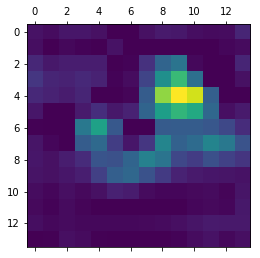

In [18]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [24]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./../data/misc/elephant_cam.jpg', superimposed_img)

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


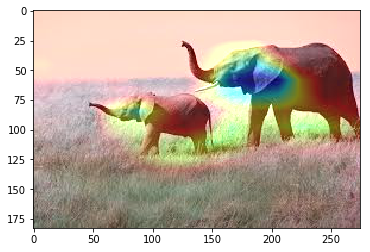

In [26]:
plt.imshow(superimposed_img.astype('int'))